In [1]:
import warnings
from copy import deepcopy
import pickle as pkl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import imblearn.over_sampling

In [3]:
from ipywidgets import interactive, FloatSlider

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

In [6]:
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve
from sklearn.pipeline import make_pipeline

In [7]:
# function cm_val creates an interactive confusion matrix on un-scaled data.
# function cm_val_scaled creates an interactive confusion matrix on scaled data.
from my_functions import cm_val
from my_functions import cm_val_scaled
# function y_pred_inverse extracts the predictive probability from predict_proba.
from my_functions import y_pred_inverse
# function plot_validation_curve_log plots a validation curve on a log scale.
# function plot_validation_curve_reg plots a validation curve on a default scale.
from my_functions import plot_validation_curve_log
from my_functions import plot_validation_curve_reg
# function plot_learning_curve_reg plots a learning curve on a default scale.
from my_functions import plot_learning_curve
# function plot_decision_tree uses graphviz to visualize the splits of a devision tree.
from my_functions import plot_decision_tree
# function train_and_calibrate_cv performs stratified shuffle split on a specified model,
# returning validation scores and roc/auc.
from my_functions import train_and_calibrate_cv

In [8]:
warnings.filterwarnings('ignore')

In [9]:
pd.set_option('display.max_colwidth', 1000)

In [10]:
pd.set_option('display.max_columns', None)

In [11]:
pd.set_option('display.float_format', lambda x: '%.1f' % x)

In [12]:
np.random.seed(42)

In [13]:
df = pd.read_pickle('df_clean.pkl')

In [14]:
df.describe()

age_at_incident  num_charges  sentence_years  years_until_charged  \
count         148703.0     148703.0        148703.0             148703.0   
mean              32.6          1.1             3.1                  0.2   
std               11.8          0.7             4.8                  0.7   
min               17.0          1.0             0.0                  0.0   
25%               23.0          1.0             1.5                  0.1   
50%               30.0          1.0             2.0                  0.1   
75%               41.0          1.0             3.0                  0.2   
max               85.0         74.0           405.0                 28.2   

       case_years  
count    148703.0  
mean          0.8  
std           6.4  
min           0.0  
25%           0.2  
50%           0.5  
75%           0.9  
max         902.4

In [15]:
df.head()

highest_charge                 offense_title       sentence_phase  \
1            True  OWN/BREED/TRAIN FIGHTING DOG  Original Sentencing   
2            True           FIRST DEGREE MURDER  Original Sentencing   
3            True   THEFT/UNAUTHD CON/>10K<100K  Original Sentencing   
4            True           FIRST DEGREE MURDER  Original Sentencing   
5            True   ATTEMPT FIRST DEGREE MURDER  Original Sentencing   

  sentence_type  age_at_incident  gender      race  current_sentence  \
1        Prison               29    Male     Black              True   
2        Prison               34    Male     Black              True   
3        Prison               31  Female     Black              True   
4          Jail               33    Male  Biracial              True   
5        Prison               26    Male     Black              True   

   num_charges trial_outcome class_adj  sentence_years  years_until_charged  \
1           74  Found Guilty     Other             3.0                  0.1   
2           59  Found Guilty         M            75.0                  0.1   
3           54  Plead Guilty     Other             4.5                  0.2   
4           42  Found Guilty         M            55.0                  0.1   
5           29  Plead Guilty         X             8.0                  0.7   

   case_years  
1         4.3  
2         2.9  
3         2.1  
4         2.3  
5         1.0

In [16]:
df.columns

Index(['highest_charge', 'offense_title', 'sentence_phase', 'sentence_type',
       'age_at_incident', 'gender', 'race', 'current_sentence', 'num_charges',
       'trial_outcome', 'class_adj', 'sentence_years', 'years_until_charged',
       'case_years'],
      dtype='object')

In [17]:
df.to_csv('df_vizualize.csv')

In [18]:
race = pd.get_dummies(df['race'])
race.columns

Index(['Asian', 'Biracial', 'Black', 'Hispanic', 'Unknown', 'White'], dtype='object')

In [19]:
# created dataframes for dummy variables for highest_charge and sentence_phase, sentence_type, gender, race, , current_sentence, trial_outcome and class_adj.
# joined dummy variable dataframes with main dataframe.
highest_charge = pd.get_dummies(df['highest_charge'])
highest_charge.drop(False, axis = 1, inplace = True)
highest_charge.rename({True: 'highest_charge_true'}, axis = 1, inplace = True)

sentence_phase = pd.get_dummies(df['sentence_phase'])
sentence_phase.columns = ['amended/corrected_sentence_phase', 'original_sentence_phase',
'probation_violation_sentence_phase', 'remanded_sentence_phase', 'resentenced_sentence_phase']

sentence_type = pd.get_dummies(df['sentence_type'])
sentence_type.columns = ['conditional_discharge_sentence','conversion_sentence',
'boot_camp_sentence', 'death_sentence', 'jail_sentence', 'prison_sentence',
'probation_sentence', 'supervision_sentence']
    
gender = pd.get_dummies(df['gender'])
gender.rename({'Male': 'male', 'Female': 'female'}, axis = 1, inplace = True)
gender.drop('female', axis = 1, inplace = True)

race = pd.get_dummies(df['race'])
race.columns = ['asian', 'biracial', 'black', 'hispanic', 'unknown_race', 'white']
# race.drop('unknown_race', axis = 1, inplace = True)

current_sentence = pd.get_dummies(df['current_sentence'])
current_sentence.rename({True: 'current_sentence_true', False: 'current_sentence_false'}, axis = 1, inplace = True)
current_sentence.drop('current_sentence_false', axis = 1, inplace = True)

trial_outcome = pd.get_dummies(df['trial_outcome'])
trial_outcome.rename({'Plead Guilty': 'plead_guilty', 'Found Guilty': 'found_guilty'}, axis = 1, inplace = True)
trial_outcome.drop('plead_guilty', axis = 1, inplace = True)

class_adj = pd.get_dummies(df['class_adj'])
class_adj.columns = ['m_class', 'other_class', 'x_class']
# class_adj.drop('other_class', axis = 1, inplace = True)

df = deepcopy(pd.concat([df, highest_charge, sentence_phase, sentence_type,
                         gender, race, current_sentence, trial_outcome, class_adj],
                        axis = 1, join = 'outer')).reset_index()

df.drop(['index', 'highest_charge', 'sentence_phase', 'sentence_type', 'gender',
         'race', 'current_sentence', 'trial_outcome', 'class_adj'], axis = 1, inplace = True)

df.rename({'highest_charge_true': 'highest_charge', 'current_sentence_true': 'current_sentence'}, axis = 1, inplace = True)

In [20]:
df.head()

offense_title  age_at_incident  num_charges  sentence_years  \
0  OWN/BREED/TRAIN FIGHTING DOG               29           74             3.0   
1           FIRST DEGREE MURDER               34           59            75.0   
2   THEFT/UNAUTHD CON/>10K<100K               31           54             4.5   
3           FIRST DEGREE MURDER               33           42            55.0   
4   ATTEMPT FIRST DEGREE MURDER               26           29             8.0   

   years_until_charged  case_years  highest_charge  \
0                  0.1         4.3               1   
1                  0.1         2.9               1   
2                  0.2         2.1               1   
3                  0.1         2.3               1   
4                  0.7         1.0               1   

   amended/corrected_sentence_phase  original_sentence_phase  \
0                                 0                        1   
1                                 0                        1   
2                                 0                        1   
3                                 0                        1   
4                                 0                        1   

   probation_violation_sentence_phase  remanded_sentence_phase  \
0                                   0                        0   
1                                   0                        0   
2                                   0                        0   
3                                   0                        0   
4                                   0                        0   

   resentenced_sentence_phase  conditional_discharge_sentence  \
0                           0                               0   
1                           0                               0   
2                           0                               0   
3                           0                               0   
4                           0                               0   

   conversion_sentence  boot_camp_sentence  death_sentence  jail_sentence  \
0                    0                   0               0              0   
1                    0                   0               0              0   
2                    0                   0               0              0   
3                    0                   0               0              1   
4                    0                   0               0              0   

   prison_sentence  probation_sentence  supervision_sentence  male  asian  \
0                1                   0                     0     1      0   
1                1                   0                     0     1      0   
2                1                   0                     0     0      0   
3                0                   0                     0     1      0   
4                1                   0                     0     1      0   

   biracial  black  hispanic  unknown_race  white  current_sentence  \
0         0      1         0             0      0                 1   
1         0      1         0             0      0                 1   
2         0      1         0             0      0                 1   
3         1      0         0             0      0                 1   
4         0      1         0             0      0                 1   

   found_guilty  m_class  other_class  x_class  
0             1        0            1        0  
1             1        1            0        0  
2             0        0            1        0  
3             1        1            0        0  
4             0        0            0        1

In [21]:
df.columns

Index(['offense_title', 'age_at_incident', 'num_charges', 'sentence_years',
       'years_until_charged', 'case_years', 'highest_charge',
       'amended/corrected_sentence_phase', 'original_sentence_phase',
       'probation_violation_sentence_phase', 'remanded_sentence_phase',
       'resentenced_sentence_phase', 'conditional_discharge_sentence',
       'conversion_sentence', 'boot_camp_sentence', 'death_sentence',
       'jail_sentence', 'prison_sentence', 'probation_sentence',
       'supervision_sentence', 'male', 'asian', 'biracial', 'black',
       'hispanic', 'unknown_race', 'white', 'current_sentence', 'found_guilty',
       'm_class', 'other_class', 'x_class'],
      dtype='object')

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148703 entries, 0 to 148702
Data columns (total 32 columns):
offense_title                         148703 non-null object
age_at_incident                       148703 non-null int64
num_charges                           148703 non-null int64
sentence_years                        148703 non-null float64
years_until_charged                   148703 non-null float64
case_years                            148703 non-null float64
highest_charge                        148703 non-null uint8
amended/corrected_sentence_phase      148703 non-null uint8
original_sentence_phase               148703 non-null uint8
probation_violation_sentence_phase    148703 non-null uint8
remanded_sentence_phase               148703 non-null uint8
resentenced_sentence_phase            148703 non-null uint8
conditional_discharge_sentence        148703 non-null uint8
conversion_sentence                   148703 non-null uint8
boot_camp_sentence                    1487

In [23]:
# checked for the number of occurances in each dummy variable.
print('highest_charge', df['highest_charge'].sum())
print('amended/corrected_sentence_phase', df['amended/corrected_sentence_phase'].sum())
print('original_sentence_phase', df['original_sentence_phase'].sum())
print('probation_violation_sentence_phase', df['probation_violation_sentence_phase'].sum())
print('remanded_sentence_phase', df['remanded_sentence_phase'].sum())
print('resentenced_sentence_phase', df['resentenced_sentence_phase'].sum())
print('conditional_discharge_sentence', df['conditional_discharge_sentence'].sum())
print('conversion_sentence', df['conversion_sentence'].sum())
print('boot_camp_sentence', df['boot_camp_sentence'].sum())
print('death_sentence', df['death_sentence'].sum())
print('jail_sentence', df['jail_sentence'].sum())
print('prison_sentence', df['prison_sentence'].sum())
print('probation_sentence', df['probation_sentence'].sum())
print('supervision_sentence', df['supervision_sentence'].sum())
print('male', df['male'].sum())
print('asian', df['asian'].sum())
print('biracial', df['biracial'].sum())
print('black', df['black'].sum())
print('hispanic', df['hispanic'].sum())
print('unknown_race', df['unknown_race'].sum())
print('white', df['white'].sum())
print('current_sentence', df['current_sentence'].sum())
print('found_guilty', df['found_guilty'].sum())
print('m_class', df['m_class'].sum())
print('other_class', df['other_class'].sum())
print('x_class', df['x_class'].sum())

highest_charge 119347
amended/corrected_sentence_phase 1035
original_sentence_phase 142262
probation_violation_sentence_phase 4154
remanded_sentence_phase 88
resentenced_sentence_phase 1164
conditional_discharge_sentence 1627
conversion_sentence 25
boot_camp_sentence 1757
death_sentence 2
jail_sentence 4317
prison_sentence 79529
probation_sentence 60351
supervision_sentence 1095
male 130806
asian 878
biracial 24615
black 99427
hispanic 2575
unknown_race 285
white 20923
current_sentence 143486
found_guilty 9559
m_class 644
other_class 137874
x_class 10185


In [24]:
feature_names = ['age_at_incident', 'num_charges', 'sentence_years',
                 'years_until_charged', 'amended/corrected_sentence_phase',
                 'original_sentence_phase', 'probation_violation_sentence_phase',
                 'resentenced_sentence_phase', 'conditional_discharge_sentence',
                 'boot_camp_sentence', 'jail_sentence', 'prison_sentence',
                 'probation_sentence', 'supervision_sentence', 'male',
                 'asian', 'biracial', 'black', 'hispanic', 'white', 'm_class', 'x_class']

X = df[feature_names]
y = df['found_guilty']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 101)

In [25]:
df['found_guilty'].value_counts()

0    139144
1      9559
Name: found_guilty, dtype: int64

In [26]:
df.groupby('found_guilty').mean()

age_at_incident  num_charges  sentence_years  \
found_guilty                                                 
0                        32.6          1.1             2.8   
1                        32.6          1.9             7.1   

              years_until_charged  case_years  highest_charge  \
found_guilty                                                    
0                             0.2         0.7             0.8   
1                             0.3         1.7             0.7   

              amended/corrected_sentence_phase  original_sentence_phase  \
found_guilty                                                              
0                                          0.0                      1.0   
1                                          0.0                      1.0   

              probation_violation_sentence_phase  remanded_sentence_phase  \
found_guilty                                                                
0                                            0.0                      0.0   
1                                            0.0                      0.0   

              resentenced_sentence_phase  conditional_discharge_sentence  \
found_guilty                                                               
0                                    0.0                             0.0   
1                                    0.0                             0.0   

              conversion_sentence  boot_camp_sentence  death_sentence  \
found_guilty                                                            
0                             0.0                 0.0             0.0   
1                             0.0                 0.0             0.0   

              jail_sentence  prison_sentence  probation_sentence  \
found_guilty                                                       
0                       0.0              0.5                 0.4   
1                       0.0              0.7                 0.3   

              supervision_sentence  male  asian  biracial  black  hispanic  \
found_guilty                                                                 
0                              0.0   0.9    0.0       0.2    0.7       0.0   
1                              0.0   0.9    0.0       0.1    0.8       0.0   

              unknown_race  white  current_sentence  m_class  other_class  \
found_guilty                                                                
0                      0.0    0.1               1.0      0.0          0.9   
1                      0.0    0.1               1.0      0.0          0.8   

              x_class  
found_guilty           
0                 0.1  
1                 0.2

In [27]:
# performed StratifiedShuffleSplit to training data (80%) into training (60%) and validation (20%)
skf = StratifiedShuffleSplit(n_splits = 5, test_size = 0.2, random_state = 101)
for train_index, validation_index in skf.split(X_train, y_train):
    X_train_6 = X_train.iloc[train_index]
    y_train_6 = y_train.iloc[train_index]
    X_validation_2 = X_train.iloc[validation_index]
    y_validation_2 = y_train.iloc[validation_index]

In [28]:
# used smote to perform upsampling with added variance for all subsets of my data,
# renaming them so that I still have the original versions that are not oversampled.
smote = imblearn.over_sampling.SMOTE(ratio = {0: 139146, 1: (139146)}, random_state = 101)
    
X_train_sm_8, y_train_sm_8 = smote.fit_sample(X_train, y_train)
X_train_sm_6, y_train_sm_6 = smote.fit_sample(X_train_6, y_train_6)
X_validation_sm_2, y_validation_sm_2 = smote.fit_sample(X_validation_2, y_validation_2)

In [29]:
# performed stratified shuffle split on my oversampled validation set
# to have a smaller sample to work with for visualizations.
skf = StratifiedShuffleSplit(n_splits = 5, test_size = 0.2, random_state = 101)
for train_index, validation_index in skf.split(X_validation_sm_2, y_validation_sm_2):
    X_train_sm_6_2 = X_validation_sm_2[train_index]
    y_train_sm_6_2 = y_validation_sm_2[train_index]
    X_validation_sm_2_2 = X_validation_sm_2[validation_index]
    y_validation_sm_2_2 = y_validation_sm_2[validation_index]

In [30]:
# printed out the shapes for all of my subsets of the original X/y.
print('X_train', X_train.shape)
print('y_train', y_train.shape)
print('X_train_6', X_train_6.shape)
print('y_train_6', y_train_6.shape)
print('X_validation_2', X_validation_2.shape)
print('y_validation_2', y_validation_2.shape)
print('X_train_sm_6', X_train_sm_6.shape)
print('y_train_sm_6', y_train_sm_6.shape)
print('X_validation_sm_2', X_validation_sm_2.shape)
print('y_validation_sm_2', y_validation_sm_2.shape)
print('X_train_sm_6_2', X_train_sm_6_2.shape)
print('y_train_sm_6_2', y_train_sm_6_2.shape)
print('X_validation_sm_2_2', X_validation_sm_2_2.shape)
print('y_validation_sm_2_2', y_validation_sm_2_2.shape)

X_train (118962, 22)
y_train (118962,)
X_train_6 (95169, 22)
y_train_6 (95169,)
X_validation_2 (23793, 22)
y_validation_2 (23793,)
X_train_sm_6 (278292, 22)
y_train_sm_6 (278292,)
X_validation_sm_2 (278292, 22)
y_validation_sm_2 (278292,)
X_train_sm_6_2 (222633, 22)
y_train_sm_6_2 (222633,)
X_validation_sm_2_2 (55659, 22)
y_validation_sm_2_2 (55659,)


### **Standard Scaler**

First use a standard scaler to level all features in the model.

In [31]:
# used standard scaler to perform fit_transform on all training data, and transform on all validation/testing data.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train_sm_6_scaled = scaler.fit_transform(X_train_sm_6)
X_train_sm_8_scaled = scaler.fit_transform(X_train_sm_8)
X_train_sm_6_2_scaled = scaler.fit_transform(X_train_sm_6_2)

X_validation_sm_2_2_scaled = scaler.transform(X_validation_sm_2_2)
X_validation_2_scaled = scaler.transform(X_validation_2)
X_validation_sm_2_scaled = scaler.transform(X_validation_sm_2)
X_test_scaled = scaler.transform(X_test)

Create a dataframe to see scaled features.

In [32]:
df_scaled = pd.DataFrame(X_train_scaled, columns = feature_names)
df_scaled.head()

age_at_incident  num_charges  sentence_years  years_until_charged  \
0             -0.7         -0.2            -0.6                 -0.1   
1             -0.7         -0.2            -0.2                 -0.2   
2              1.0         -0.2            -0.2                  2.6   
3             -0.3         -0.2            -0.4                 -0.2   
4             -0.1         -0.2            -0.4                 -0.1   

   amended/corrected_sentence_phase  original_sentence_phase  \
0                              -0.1                      0.2   
1                              -0.1                      0.2   
2                              -0.1                      0.2   
3                              -0.1                      0.2   
4                              -0.1                      0.2   

   probation_violation_sentence_phase  resentenced_sentence_phase  \
0                                -0.2                        -0.1   
1                                -0.2                        -0.1   
2                                -0.2                        -0.1   
3                                -0.2                        -0.1   
4                                -0.2                        -0.1   

   conditional_discharge_sentence  boot_camp_sentence  jail_sentence  \
0                            -0.1                 9.1           -0.2   
1                            -0.1                -0.1           -0.2   
2                            -0.1                -0.1           -0.2   
3                            -0.1                -0.1           -0.2   
4                            -0.1                -0.1           -0.2   

   prison_sentence  probation_sentence  supervision_sentence  male  asian  \
0             -1.1                -0.8                  -0.1   0.4   -0.1   
1              0.9                -0.8                  -0.1   0.4   -0.1   
2             -1.1                 1.2                  -0.1   0.4   -0.1   
3              0.9                -0.8                  -0.1   0.4   -0.1   
4             -1.1                 1.2                  -0.1  -2.7   -0.1   

   biracial  black  hispanic  white  m_class  x_class  
0      -0.4    0.7      -0.1   -0.4     -0.1     -0.3  
1      -0.4    0.7      -0.1   -0.4     -0.1     -0.3  
2       2.3   -1.4      -0.1   -0.4     -0.1     -0.3  
3      -0.4    0.7      -0.1   -0.4     -0.1     -0.3  
4      -0.4    0.7      -0.1   -0.4     -0.1     -0.3

In [33]:
# performed a naive logistic regression (no hyperparameters) with l1 penalty.
logreg = LogisticRegression(penalty = 'l1', random_state = 101)
logreg.fit(X_train_sm_6_scaled, y_train_sm_6)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=101, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [34]:
y_pred_proba_1 = y_pred_inverse(logreg.predict_proba(X_validation_2_scaled))
metrics.roc_auc_score(y_validation_2, y_pred_proba_1)

0.7414754392836004

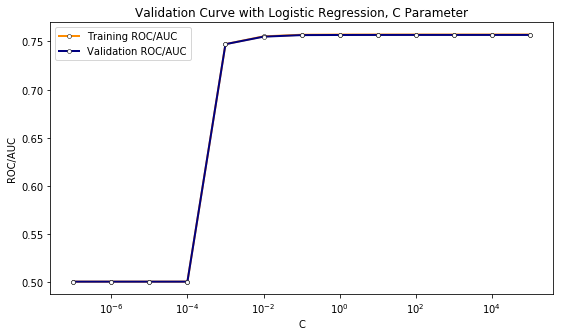

In [35]:
# plotting validation curve on log scale for a given logspace.
title = 'Validation Curve with Logistic Regression, C Parameter'
plot_validation_curve_log(LogisticRegression(penalty = 'l1', random_state = 101), 'C', np.logspace(-7, 5, 13), title, X_validation_sm_2_2_scaled, y_validation_sm_2_2)

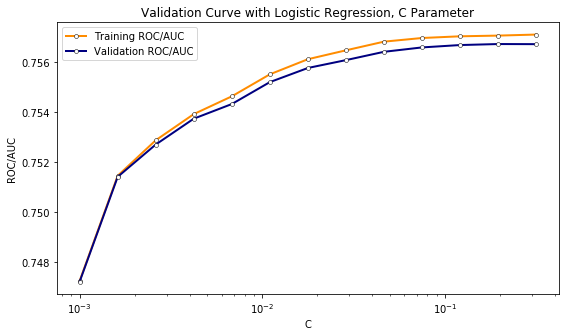

In [36]:
# plotting validation curve on log scale for a given logspace.
title = 'Validation Curve with Logistic Regression, C Parameter'
plot_validation_curve_log(LogisticRegression(penalty = 'l1', random_state = 101), 'C', np.logspace(-3, -.5, 13), title, X_validation_sm_2_2_scaled, y_validation_sm_2_2)

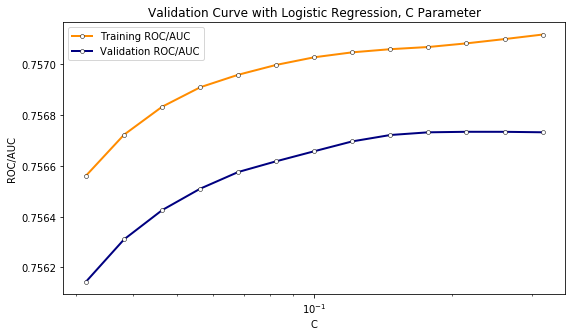

In [37]:
# plotting validation curve on log scale for a given logspace.
title = 'Validation Curve with Logistic Regression, C Parameter'
plot_validation_curve_log(LogisticRegression(penalty = 'l1', random_state = 101), 'C', np.logspace(-1.5, -.5, 13), title, X_validation_sm_2_2_scaled, y_validation_sm_2_2)

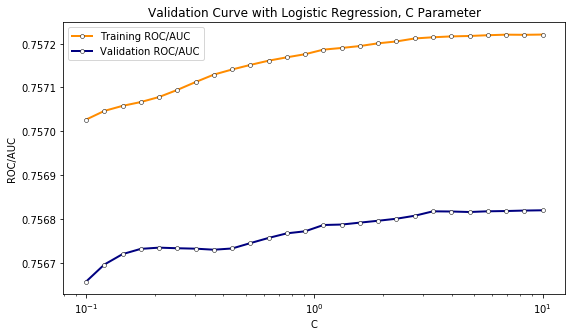

In [38]:
# plotting validation curve on log scale for a given logspace.
title = 'Validation Curve with Logistic Regression, C Parameter'
plot_validation_curve_log(LogisticRegression(penalty = 'l1', random_state = 101), 'C', np.logspace(-1, 1, 26), title, X_validation_sm_2_2_scaled, y_validation_sm_2_2)

In [39]:
param_grid = {'C': np.logspace(-1, 1, 26)}
grid = GridSearchCV(LogisticRegression(penalty = 'l1', random_state = 101), param_grid, cv = 3, scoring = 'roc_auc', refit = True, n_jobs = -1)
grid.fit(X_train_sm_6_scaled, y_train_sm_6)
grid_predictions = grid.predict(X_validation_2_scaled)

In [40]:
grid.best_params_

{'C': 8.317637711026709}

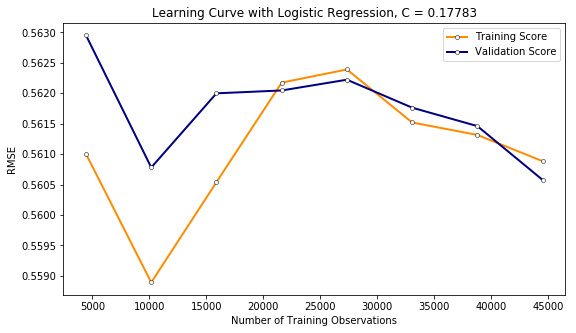

In [41]:
# plotting learning curve on at grid.best_params_
title = 'Learning Curve with Logistic Regression, C = 0.17783'
plot_learning_curve(LogisticRegression(C = 8.317637711026709, penalty = 'l1', random_state = 101), title, X_validation_sm_2_2_scaled, y_validation_sm_2_2)

In [42]:
logreg = LogisticRegression(C = 8.317637711026709, penalty = 'l1', random_state = 101)
logreg.fit(X_train_sm_6_scaled, y_train_sm_6)

LogisticRegression(C=8.317637711026709, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=101,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [43]:
y_pred_2 = logreg.predict(X_validation_2_scaled)
y_pred_proba_2 = y_pred_inverse(logreg.predict_proba(X_validation_2_scaled))
metrics.roc_auc_score(y_validation_2, y_pred_proba_2)

0.7414883667513774

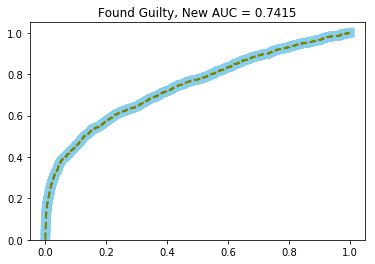

In [44]:
# comparing roc/auc from before and after hyperparameter tuning.
fpr1, tpr1, _ = metrics.roc_curve(y_validation_2, y_pred_proba_1)
roc1_df = pd.DataFrame(fpr1, tpr1).reset_index()
roc1_df.rename({'index': 'fpr1', 0: 'tpr1'}, axis = 1, inplace = True)

auc1 = metrics.roc_auc_score(y_validation_2, y_pred_proba_1)

fpr2, tpr2, _ = metrics.roc_curve(y_validation_2, y_pred_proba_2)
roc2_df = pd.DataFrame(fpr2, tpr2).reset_index()
roc2_df.rename({'index': 'fpr2', 0: 'tpr2'}, axis = 1, inplace = True)

auc2 = metrics.roc_auc_score(y_validation_2, y_pred_proba_2)

sns.set_context(font_scale = 1.2)
plt.plot('tpr1', 'fpr1', data = roc1_df, color = 'skyblue', linewidth = 10)
plt.plot('tpr2', 'fpr2', data = roc2_df, color = 'olive', linewidth = 2, linestyle = 'dashed')
plt.ylim(0, )
plt.title("Found Guilty, New AUC = " + str(auc2.round(4)));

In [45]:
# created a confusion matrix for tuned model with a dynamic threshold.
print('\n', metrics.classification_report(y_validation_2, y_pred_2))

interactive(lambda threshold: cm_val_scaled(logreg, threshold), threshold = (0.0,1.0,0.02))


               precision    recall  f1-score   support

           0       0.96      0.86      0.91     22268
           1       0.20      0.52      0.29      1525

   micro avg       0.83      0.83      0.83     23793
   macro avg       0.58      0.69      0.60     23793
weighted avg       0.91      0.83      0.87     23793



interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.02), Output()), _dom_cla…

In [46]:
logreg = LogisticRegression(C = 8.317637711026709, penalty = 'l1', random_state = 101)
logreg.fit(X_train_sm_8_scaled, y_train_sm_8)

LogisticRegression(C=8.317637711026709, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=101,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [47]:
y_pred_2 = logreg.predict(X_test_scaled)
y_pred_proba_2 = y_pred_inverse(logreg.predict_proba(X_test_scaled))
metrics.roc_auc_score(y_test, y_pred_proba_2)

0.7374695588352002

In [48]:
y_test.value_counts()

0    27806
1     1935
Name: found_guilty, dtype: int64


               precision    recall  f1-score   support

           0       0.96      0.86      0.91     27806
           1       0.20      0.51      0.29      1935

   micro avg       0.84      0.84      0.84     29741
   macro avg       0.58      0.68      0.60     29741
weighted avg       0.91      0.84      0.87     29741



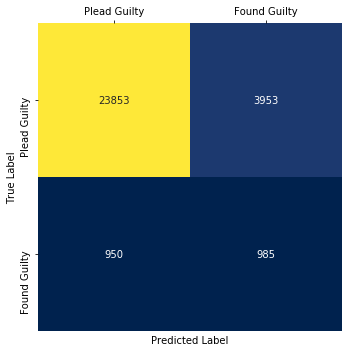

In [49]:
# created new confusion matrix for tuned model.
print('\n', metrics.classification_report(y_test, y_pred_2))

df_cm = pd.DataFrame(metrics.confusion_matrix(y_test, y_pred_2))
df_cm.rename({0: 'Plead Guilty', 1: 'Found Guilty'}, axis = 1, inplace = True)
df_cm.rename(index = {0: 'Plead Guilty', 1: 'Found Guilty'}, inplace = True)

fig, ax = plt.subplots(1, 1, figsize = (5, 5))
sns.set_context(font_scale = 1.2)
sns.heatmap(df_cm, annot = True, fmt = 'g', cbar = False, cmap = 'cividis')
ax.set_ylabel('True Label')
ax.set_xlabel('Predicted Label');
ax.xaxis.set_ticks_position('top') 
plt.tight_layout()

In [50]:
# performed a naive logistic regression (no hyperparameters) with l2 penalty.
logreg = LogisticRegression(penalty = 'l2', random_state = 101)
logreg.fit(X_train_sm_6_scaled, y_train_sm_6)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=101, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [51]:
y_pred_proba_1 = y_pred_inverse(logreg.predict_proba(X_validation_2))
metrics.roc_auc_score(y_validation_2, y_pred_proba_1)

0.687773898883055

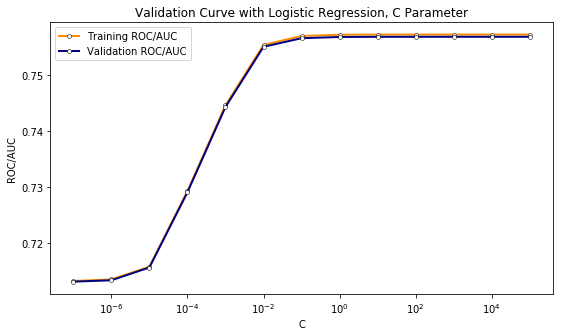

In [52]:
# plotting validation curve on log scale for a given logspace.
title = 'Validation Curve with Logistic Regression, C Parameter'
plot_validation_curve_log(LogisticRegression(penalty = 'l2', random_state = 101), 'C', np.logspace(-7, 5, 13), title, X_validation_sm_2_2_scaled, y_validation_sm_2_2)

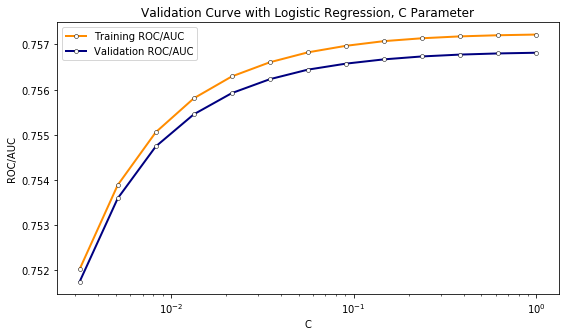

In [53]:
# plotting validation curve on log scale for a given logspace.
title = 'Validation Curve with Logistic Regression, C Parameter'
plot_validation_curve_log(LogisticRegression(penalty = 'l2', random_state = 101), 'C', np.logspace(-2.5, 0, 13), title, X_validation_sm_2_2_scaled, y_validation_sm_2_2)

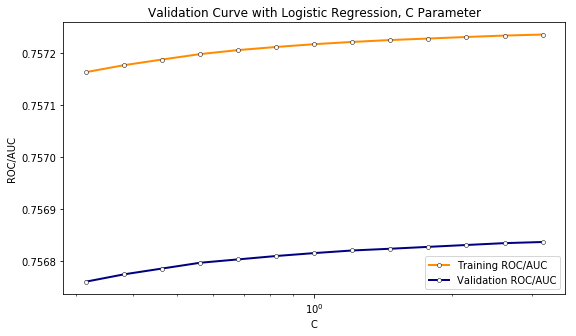

In [54]:
# plotting validation curve on log scale for a given logspace.
title = 'Validation Curve with Logistic Regression, C Parameter'
plot_validation_curve_log(LogisticRegression(penalty = 'l2', random_state = 101), 'C', np.logspace(-.5, .5, 13), title, X_validation_sm_2_2_scaled, y_validation_sm_2_2)

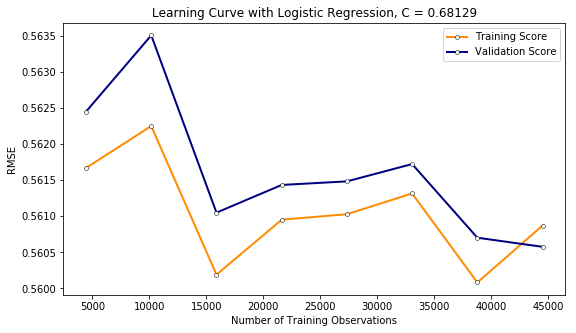

In [55]:
# plotting learning curve on at best C value.
title = 'Learning Curve with Logistic Regression, C = 0.68129'
plot_learning_curve(LogisticRegression(C = 0.68129, penalty = 'l2', random_state = 101), title, X_validation_sm_2_2_scaled, y_validation_sm_2_2)

In [56]:
logreg = LogisticRegression(C = 0.68129, penalty = 'l2', random_state = 101)
logreg.fit(X_train_sm_6_scaled, y_train_sm_6)

LogisticRegression(C=0.68129, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=101,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [57]:
y_pred_2 = logreg.predict(X_validation_2_scaled)
y_pred_proba_2 = y_pred_inverse(logreg.predict_proba(X_validation_2_scaled))
metrics.roc_auc_score(y_validation_2, y_pred_proba_2)

0.741434801685577

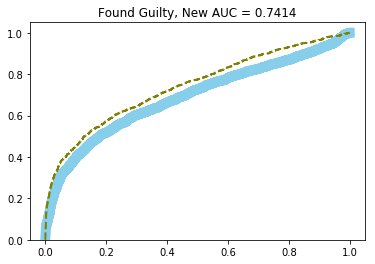

In [58]:
# comparing roc/auc from before and after hyperparameter tuning.
fpr1, tpr1, _ = metrics.roc_curve(y_validation_2, y_pred_proba_1)
roc1_df = pd.DataFrame(fpr1, tpr1).reset_index()
roc1_df.rename({'index': 'fpr1', 0: 'tpr1'}, axis = 1, inplace = True)

auc1 = metrics.roc_auc_score(y_validation_2, y_pred_proba_1)

fpr2, tpr2, _ = metrics.roc_curve(y_validation_2, y_pred_proba_2)
roc2_df = pd.DataFrame(fpr2, tpr2).reset_index()
roc2_df.rename({'index': 'fpr2', 0: 'tpr2'}, axis = 1, inplace = True)

auc2 = metrics.roc_auc_score(y_validation_2, y_pred_proba_2)

sns.set_context(font_scale = 1.2)
plt.plot('tpr1', 'fpr1', data = roc1_df, color = 'skyblue', linewidth = 10)
plt.plot('tpr2', 'fpr2', data = roc2_df, color = 'olive', linewidth = 2, linestyle = 'dashed')
plt.ylim(0, )
plt.title("Found Guilty, New AUC = " + str(auc2.round(4)));

In [59]:
# created a confusion matrix for tuned model with a dynamic threshold.
print('\n', metrics.classification_report(y_validation_2, y_pred_2))

interactive(lambda threshold: cm_val_scaled(logreg, threshold), threshold = (0.0,1.0,0.02))


               precision    recall  f1-score   support

           0       0.96      0.86      0.91     22268
           1       0.20      0.51      0.29      1525

   micro avg       0.84      0.84      0.84     23793
   macro avg       0.58      0.69      0.60     23793
weighted avg       0.91      0.84      0.87     23793



interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.02), Output()), _dom_cla…

In [60]:
# performed a Naive Bayes with no hyperparameters.
gnb = GaussianNB()
gnb.fit(X_train_sm_6, y_train_sm_6)

GaussianNB(priors=None, var_smoothing=1e-09)

In [61]:
y_pred_proba_1 = y_pred_inverse(gnb.predict_proba(X_validation_2))
metrics.roc_auc_score(y_validation_2, y_pred_proba_1)

0.7073045493496511

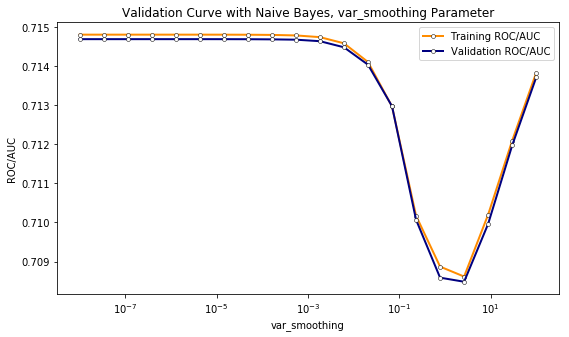

In [62]:
title = 'Validation Curve with Naive Bayes, var_smoothing Parameter' 
plot_validation_curve_log(GaussianNB(), 'var_smoothing', np.logspace(-8, 2, 20), title, X_validation_sm_2_2_scaled, y_validation_sm_2_2)

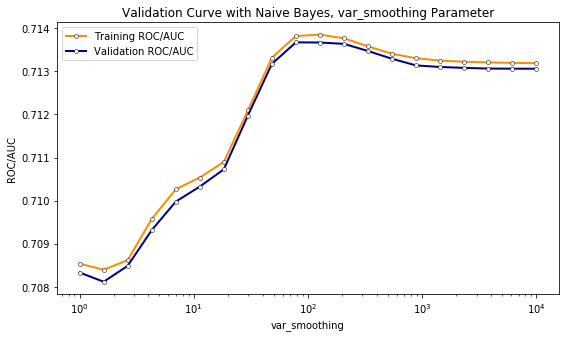

In [63]:
title = 'Validation Curve with Naive Bayes, var_smoothing Parameter' 
plot_validation_curve_log(GaussianNB(), 'var_smoothing', np.logspace(0, 4, 20), title, X_validation_sm_2_2_scaled, y_validation_sm_2_2)

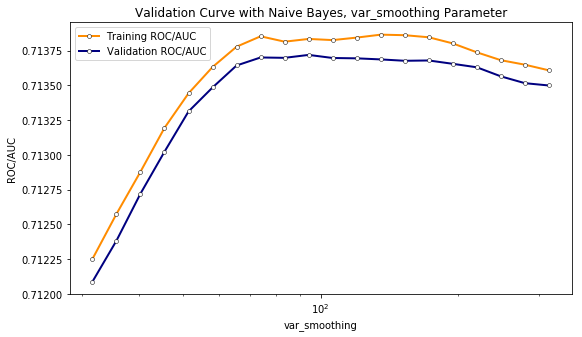

In [64]:
title = 'Validation Curve with Naive Bayes, var_smoothing Parameter' 
plot_validation_curve_log(GaussianNB(), 'var_smoothing', np.logspace(1.5, 2.5, 20), title, X_validation_sm_2_2_scaled, y_validation_sm_2_2)

In [65]:
param_grid = {'var_smoothing': np.logspace(1.5, 2.5, 20)}
grid = GridSearchCV(GaussianNB(), param_grid, cv = 3, scoring = 'roc_auc', refit = True, n_jobs = -1)
grid.fit(X_train_sm_6, y_train_sm_6)
grid_predictions = grid.predict(X_validation_sm_2)

In [66]:
grid.best_params_

{'var_smoothing': 31.622776601683793}

In [67]:
gnb = GaussianNB(var_smoothing = 31.622776601683793)
gnb.fit(X_train_sm_6, y_train_sm_6)

GaussianNB(priors=None, var_smoothing=31.622776601683793)

In [68]:
y_pred_2 = gnb.predict(X_validation_2)
y_pred_proba_2 = y_pred_inverse(gnb.predict_proba(X_validation_2))
metrics.roc_auc_score(y_validation_2, y_pred_proba_2)

0.6533540005948402


               precision    recall  f1-score   support

           0       0.94      1.00      0.97     22268
           1       0.50      0.07      0.12      1525

   micro avg       0.94      0.94      0.94     23793
   macro avg       0.72      0.53      0.55     23793
weighted avg       0.91      0.94      0.91     23793



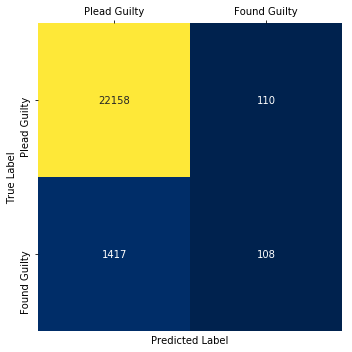

In [69]:
# created new confusion matrix for tuned model.
print('\n', metrics.classification_report(y_validation_2, y_pred_2))

df_cm = pd.DataFrame(metrics.confusion_matrix(y_validation_2, y_pred_2))
df_cm.rename({0: 'Plead Guilty', 1: 'Found Guilty'}, axis = 1, inplace = True)
df_cm.rename(index = {0: 'Plead Guilty', 1: 'Found Guilty'}, inplace = True)

fig, ax = plt.subplots(1, 1, figsize = (5, 5))
sns.set_context(font_scale = 1.2)
sns.heatmap(df_cm, annot = True, fmt = 'g', cbar = False, cmap = 'cividis')
ax.set_ylabel('True Label')
ax.set_xlabel('Predicted Label');
ax.xaxis.set_ticks_position('top') 
plt.tight_layout()

In [70]:
# performed a naive decision tree (no hyperparameters).
dtree = DecisionTreeClassifier(random_state = 101)
dtree.fit(X_train_sm_6, y_train_sm_6)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=101,
            splitter='best')

In [71]:
y_pred_proba_1 = y_pred_inverse(dtree.predict_proba(X_validation_2))
metrics.roc_auc_score(y_validation_2, y_pred_proba_1)

0.5949125555454126

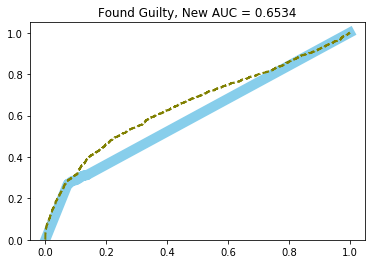

In [72]:
# comparing roc/auc from before and after hyperparameter tuning.
fpr1, tpr1, _ = metrics.roc_curve(y_validation_2, y_pred_proba_1)
roc1_df = pd.DataFrame(fpr1, tpr1).reset_index()
roc1_df.rename({'index': 'fpr1', 0: 'tpr1'}, axis = 1, inplace = True)

auc1 = metrics.roc_auc_score(y_validation_2, y_pred_proba_1)

fpr2, tpr2, _ = metrics.roc_curve(y_validation_2, y_pred_proba_2)
roc2_df = pd.DataFrame(fpr2, tpr2).reset_index()
roc2_df.rename({'index': 'fpr2', 0: 'tpr2'}, axis = 1, inplace = True)

auc2 = metrics.roc_auc_score(y_validation_2, y_pred_proba_2)

sns.set_context(font_scale = 1.2)
plt.plot('tpr1', 'fpr1', data = roc1_df, color = 'skyblue', linewidth = 10)
plt.plot('tpr2', 'fpr2', data = roc2_df, color = 'olive', linewidth = 2, linestyle = 'dashed')
plt.ylim(0, )
plt.title("Found Guilty, New AUC = " + str(auc2.round(4)));

In [73]:
param_grid = {'max_depth': np.arange(2, 16), 'min_samples_split': np.arange(2, 8), 'min_samples_leaf': np.arange(2, 8)}
rscv = RandomizedSearchCV(DecisionTreeClassifier(random_state = 101), param_grid, cv = 5, scoring = 'roc_auc', refit = True, n_jobs = -1)
rscv.fit(X_train_sm_6, y_train_sm_6)
rscv_predictions = rscv.predict(X_validation_2)

In [74]:
rscv.best_params_

{'min_samples_split': 2, 'min_samples_leaf': 6, 'max_depth': 13}

In [75]:
param_grid = {'max_depth': np.arange(5, 10), 'min_samples_split': np.arange(4, 12), 'min_samples_leaf': np.arange(4, 12)}
rscv = RandomizedSearchCV(DecisionTreeClassifier(random_state = 101), param_grid, cv = 5, scoring = 'roc_auc', refit = True, n_jobs = -1)
rscv.fit(X_train_sm_6, y_train_sm_6)
rscv_predictions = rscv.predict(X_validation_2)

In [76]:
rscv.best_params_

{'min_samples_split': 8, 'min_samples_leaf': 7, 'max_depth': 9}

In [77]:
param_grid = {'max_depth': np.arange(5, 10), 'min_samples_split': np.arange(6, 13), 'min_samples_leaf': np.arange(6, 13)}
grid = GridSearchCV(DecisionTreeClassifier(random_state = 101), param_grid, cv = 3, scoring = 'roc_auc', refit = True, n_jobs = -1)
grid.fit(X_train_sm_6, y_train_sm_6)
grid_predictions = grid.predict(X_validation_2)

In [78]:
grid.best_params_

{'max_depth': 9, 'min_samples_leaf': 6, 'min_samples_split': 6}

In [79]:
param_grid = {'max_depth': np.arange(7, 13), 'min_samples_split': np.arange(3, 11), 'min_samples_leaf': np.arange(4, 10)}
grid = GridSearchCV(DecisionTreeClassifier(random_state = 101), param_grid, cv = 3, scoring = 'roc_auc', refit = True, n_jobs = -1)
grid.fit(X_train_sm_6, y_train_sm_6)
grid_predictions = grid.predict(X_validation_2)

In [80]:
grid.best_params_

{'max_depth': 12, 'min_samples_leaf': 4, 'min_samples_split': 9}

In [81]:
param_grid = {'max_depth': np.arange(8, 16), 'min_samples_split': np.arange(6, 13), 'min_samples_leaf': np.arange(2, 8)}
grid = GridSearchCV(DecisionTreeClassifier(random_state = 101), param_grid, cv = 3, scoring = 'roc_auc', refit = True, n_jobs = -1)
grid.fit(X_train_sm_6, y_train_sm_6)
grid_predictions = grid.predict(X_validation_2)

In [82]:
grid.best_params_

{'max_depth': 15, 'min_samples_leaf': 2, 'min_samples_split': 12}

In [83]:
dtree = DecisionTreeClassifier(max_depth = 15, min_samples_split = 12, min_samples_leaf = 2, random_state = 101)
dtree.fit(X_train_sm_6, y_train_sm_6)
y_pred_2 = dtree.predict(X_validation_2)
y_pred_proba_2 = y_pred_inverse(dtree.predict_proba(X_validation_2))
metrics.roc_auc_score(y_validation_2, y_pred_proba_2)

0.6549286486231806

In [84]:
plot_decision_tree(dtree, feature_names, ['Plead Guilty', ' Found Guilty'])

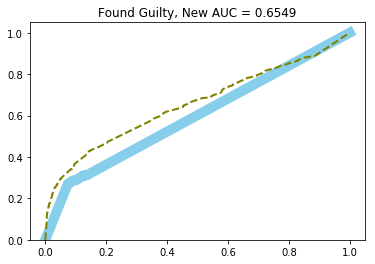

In [85]:
# comparing roc/auc from before and after hyperparameter tuning.
fpr1, tpr1, _ = metrics.roc_curve(y_validation_2, y_pred_proba_1)
roc1_df = pd.DataFrame(fpr1, tpr1).reset_index()
roc1_df.rename({'index': 'fpr1', 0: 'tpr1'}, axis = 1, inplace = True)

auc1 = metrics.roc_auc_score(y_validation_2, y_pred_proba_1)

fpr2, tpr2, _ = metrics.roc_curve(y_validation_2, y_pred_proba_2)
roc2_df = pd.DataFrame(fpr2, tpr2).reset_index()
roc2_df.rename({'index': 'fpr2', 0: 'tpr2'}, axis = 1, inplace = True)

auc2 = metrics.roc_auc_score(y_validation_2, y_pred_proba_2)

sns.set_context(font_scale = 1.2)
plt.plot('tpr1', 'fpr1', data = roc1_df, color = 'skyblue', linewidth = 10)
plt.plot('tpr2', 'fpr2', data = roc2_df, color = 'olive', linewidth = 2, linestyle = 'dashed')
plt.ylim(0, )
plt.title("Found Guilty, New AUC = " + str(auc2.round(4)));


               precision    recall  f1-score   support

           0       0.95      0.91      0.93     22268
           1       0.21      0.34      0.26      1525

   micro avg       0.88      0.88      0.88     23793
   macro avg       0.58      0.63      0.60     23793
weighted avg       0.91      0.88      0.89     23793



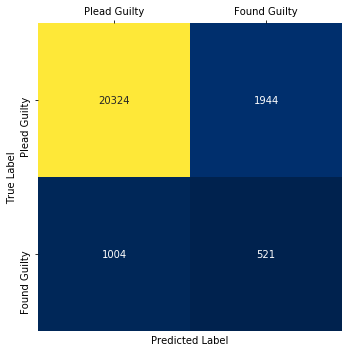

In [86]:
# created new confusion matrix for tuned model.
print('\n', metrics.classification_report(y_validation_2, y_pred_2))

df_cm = pd.DataFrame(metrics.confusion_matrix(y_validation_2, y_pred_2))
df_cm.rename({0: 'Plead Guilty', 1: 'Found Guilty'}, axis = 1, inplace = True)
df_cm.rename(index = {0: 'Plead Guilty', 1: 'Found Guilty'}, inplace = True)

fig, ax = plt.subplots(1, 1, figsize = (5, 5))
sns.set_context(font_scale = 1.2)
sns.heatmap(df_cm, annot = True, fmt = 'g', cbar = False, cmap = 'cividis')
ax.set_ylabel('True Label')
ax.set_xlabel('Predicted Label');
ax.xaxis.set_ticks_position('top') 
plt.tight_layout()

In [87]:
# performed a naive random forest (no hyperparameters).
rfc = RandomForestClassifier(random_state = 101)
rfc.fit(X_train_sm_6, y_train_sm_6)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=101, verbose=0, warm_start=False)

In [88]:
y_pred_1 = rfc.predict(X_validation_2)
y_pred_proba_1 = y_pred_inverse(rfc.predict_proba(X_validation_2))
metrics.roc_auc_score(y_validation_2, y_pred_proba_1)

0.6752305300261789

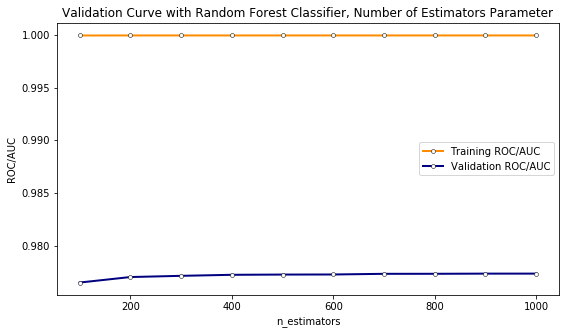

In [89]:
title = 'Validation Curve with Random Forest Classifier, Number of Estimators Parameter'
plot_validation_curve_reg(RandomForestClassifier(random_state = 101), 'n_estimators', [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000], title, X_validation_sm_2_2, y_validation_sm_2_2)

In [90]:
rfc = RandomForestClassifier(n_estimators = 600, random_state = 101)
rfc.fit(X_train_sm_6, y_train_sm_6)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=600, n_jobs=None,
            oob_score=False, random_state=101, verbose=0, warm_start=False)

In [91]:
y_pred_1 = rfc.predict(X_validation_2)
y_pred_proba_1 = y_pred_inverse(rfc.predict_proba(X_validation_2))
metrics.roc_auc_score(y_validation_2, y_pred_proba_1)

0.6980612773751644


               precision    recall  f1-score   support

           0       0.95      0.93      0.94     22268
           1       0.22      0.28      0.25      1525

   micro avg       0.89      0.89      0.89     23793
   macro avg       0.59      0.61      0.59     23793
weighted avg       0.90      0.89      0.90     23793



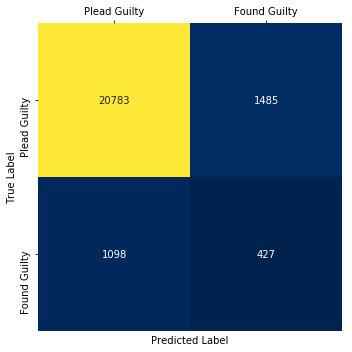

In [92]:
# created new confusion matrix for tuned model.
print('\n', metrics.classification_report(y_validation_2, y_pred_1))

df_cm = pd.DataFrame(metrics.confusion_matrix(y_validation_2, y_pred_1))
df_cm.rename({0: 'Plead Guilty', 1: 'Found Guilty'}, axis = 1, inplace = True)
df_cm.rename(index = {0: 'Plead Guilty', 1: 'Found Guilty'}, inplace = True)

fig, ax = plt.subplots(1, 1, figsize = (5, 5))
sns.set_context(font_scale = 1.2)
sns.heatmap(df_cm, annot = True, fmt = 'g', cbar = False, cmap = 'cividis')
ax.set_ylabel('True Label')
ax.set_xlabel('Predicted Label');
ax.xaxis.set_ticks_position('top') 
plt.tight_layout()

In [93]:
param_grid = {'max_depth': np.arange(5, 13), 'min_samples_split': np.arange(3, 13), 'min_samples_leaf': np.arange(3, 13)}
grid = GridSearchCV(RandomForestClassifier(random_state = 101), param_grid, cv = 3, scoring = 'roc_auc', refit = True, n_jobs = -1)
grid.fit(X_train_sm_6, y_train_sm_6)
grid_predictions = grid.predict(X_validation_sm_2)

In [94]:
grid.best_params_

{'max_depth': 12, 'min_samples_leaf': 3, 'min_samples_split': 7}

In [95]:
rfc = RandomForestClassifier(n_estimators = 600, max_depth = 12, min_samples_leaf = 3, min_samples_split = 7, random_state = 101)
rfc.fit(X_train_sm_6, y_train_sm_6)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=12, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=7,
            min_weight_fraction_leaf=0.0, n_estimators=600, n_jobs=None,
            oob_score=False, random_state=101, verbose=0, warm_start=False)

In [96]:
y_pred_2 = rfc.predict(X_validation_2)
y_pred_proba_2 = y_pred_inverse(rfc.predict_proba(X_validation_2))
metrics.roc_auc_score(y_validation_2, y_pred_proba_2)

0.730889845606575

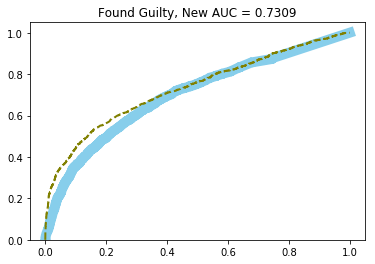

In [97]:
# comparing roc/auc from before and after hyperparameter tuning.
fpr1, tpr1, _ = metrics.roc_curve(y_validation_2, y_pred_proba_1)
roc1_df = pd.DataFrame(fpr1, tpr1).reset_index()
roc1_df.rename({'index': 'fpr1', 0: 'tpr1'}, axis = 1, inplace = True)

auc1 = metrics.roc_auc_score(y_validation_2, y_pred_proba_1)

fpr2, tpr2, _ = metrics.roc_curve(y_validation_2, y_pred_proba_2)
roc2_df = pd.DataFrame(fpr2, tpr2).reset_index()
roc2_df.rename({'index': 'fpr2', 0: 'tpr2'}, axis = 1, inplace = True)

auc2 = metrics.roc_auc_score(y_validation_2, y_pred_proba_2)

sns.set_context(font_scale = 1.2)
plt.plot('tpr1', 'fpr1', data = roc1_df, color = 'skyblue', linewidth = 10)
plt.plot('tpr2', 'fpr2', data = roc2_df, color = 'olive', linewidth = 2, linestyle = 'dashed')
plt.ylim(0, )
plt.title("Found Guilty, New AUC = " + str(auc2.round(4)));

In [98]:
rfc = RandomForestClassifier(n_estimators = 600, random_state = 101)
rfc.fit(X_train_sm_6, y_train_sm_6)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=600, n_jobs=None,
            oob_score=False, random_state=101, verbose=0, warm_start=False)

In [99]:
y_pred = rfc.predict(X_test)
y_pred_proba = y_pred_inverse(rfc.predict_proba(X_test))
metrics.roc_auc_score(y_test, y_pred)

0.6049360547358301

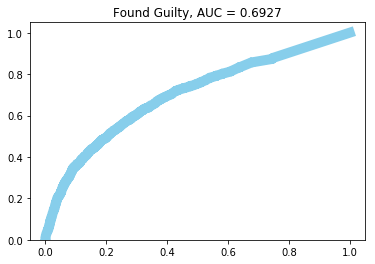

In [100]:
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
roc_df = pd.DataFrame(fpr1, tpr1).reset_index()
roc_df.rename({'index': 'fpr', 0: 'tpr'}, axis = 1, inplace = True)

auc = metrics.roc_auc_score(y_test, y_pred_proba)

sns.set_context(font_scale = 1.2)
plt.plot('tpr', 'fpr', data = roc_df, color = 'skyblue', linewidth = 10)
plt.ylim(0, )
plt.title("Found Guilty, AUC = " + str(auc.round(4)));


               precision    recall  f1-score   support

           0       0.96      0.89      0.92     22268
           1       0.22      0.47      0.30      1525

   micro avg       0.86      0.86      0.86     23793
   macro avg       0.59      0.68      0.61     23793
weighted avg       0.91      0.86      0.88     23793



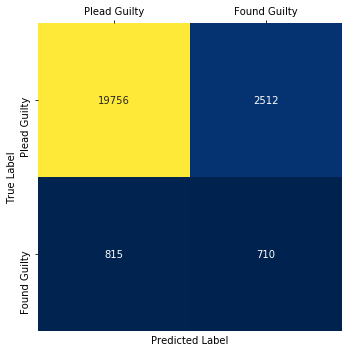

In [101]:
# created new confusion matrix for tuned model.
print('\n', metrics.classification_report(y_validation_2, y_pred_2))

df_cm = pd.DataFrame(metrics.confusion_matrix(y_validation_2, y_pred_2))
df_cm.rename({0: 'Plead Guilty', 1: 'Found Guilty'}, axis = 1, inplace = True)
df_cm.rename(index = {0: 'Plead Guilty', 1: 'Found Guilty'}, inplace = True)

fig, ax = plt.subplots(1, 1, figsize = (5, 5))
sns.set_context(font_scale = 1.2)
sns.heatmap(df_cm, annot = True, fmt = 'g', cbar = False, cmap = 'cividis')
ax.set_ylabel('True Label')
ax.set_xlabel('Predicted Label');
ax.xaxis.set_ticks_position('top') 
plt.tight_layout()

In [102]:
# def train_and_calibrate_cv(models, X_train, y_train, cv = 5):
#     model_scores = {}
#     for i, model in enumerate(models):
#         model_fold_scores = []
#         skf = StratifiedShuffleSplit(n_splits = cv, test_size = 0.2, random_state = 101)
#         for train_index, validation_index in skf.split(X_train_sm, y_train_sm):
#             X_train_v = df[feature_names].iloc[train_index]
#             X_validation_v = df[feature_names].iloc[validation_index]
#             y_train_v = df['found_guilty'].iloc[train_index]
#             y_validation_v = df['found_guilty'].iloc[validation_index]
#             model.fit(X_train_v, y_train_v)
#             try:
#                 y_pred_proba_v = y_pred_inverse(model.predict_proba(X_validation_v))
#                 model_fold_scores.append(metrics.roc_auc_score(y_validation_v, y_pred_proba_v))
#             except:
#                 y_pred_v = model.predict(X_validation_v)
#                 model_fold_scores.append(metrics.roc_auc_score(y_validation_v, y_pred_v))
#         model_scores[model] = pd.Series(model_fold_scores).mean()
#     return model_scores

In [103]:
# models = [LogisticRegression(penalty = 'l1', random_state = 101),
#           LogisticRegression(C = 3.162278, penalty = 'l2', random_state = 101)]

# train_and_calibrate_cv(models, X_train_scaled_sm, y_train_sm, cv = 5)

In [104]:
# models = [DecisionTreeClassifier(max_depth = 8, min_samples_split = 8, min_samples_leaf = 20, random_state = 101),
#           GaussianNB()]

# train_and_calibrate_cv(models, X_train_sm, y_train_sm, cv = 5)

In [105]:
# feature_names = ['age_at_incident', 'num_charges', 'sentence_years',
#                  'years_until_charged', 'amended/corrected_sentence_phase',
#                  'original_sentence_phase', 'probation_violation_sentence_phase',
#                  'resentenced_sentence_phase', 'conditional_discharge_sentence',
#                  'boot_camp_sentence', 'jail_sentence', 'prison_sentence',
#                  'probation_sentence', 'supervision_sentence', 'male',
#                  'asian', 'biracial', 'black', 'hispanic', 'white', 'm_class', 'x_class']

# X = df[feature_names]
# y = df['found_guilty']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 101)

# pipelines = {
#     'l1' : make_pipeline(StandardScaler(),LogisticRegression(penalty = 'l1', random_state = 101)),
#     'l2' : make_pipeline(StandardScaler(),LogisticRegression(penalty = 'l2', random_state = 101)),
#     'rf' : make_pipeline(RandomForestClassifier(random_state = 101)),
# #     'gnb' : make_pipeline(GaussianNB())
# }

# '''
# Define a dictionary of hyperparameters for each model
# '''

# # logistic regression L1 norm model hyperparameters
# l1_hyperparameters = {
#     'logisticregression__C' : np.logspace(-7, 5, 13),
# }

# # logistic regression L1 norm model hyperparameters
# l2_hyperparameters = {
#     'logisticregression__C' : np.logspace(-7, 5, 13),
# }

# # random forest model hyperparameters
# rf_hyperparameters = {
#     'randomforestclassifier__n_estimators': [100, 200],
#     'randomforestclassifier__max_features': ['auto', 'sqrt', 0.33]
# }

# # gradient boost model hyperparameters
# gb_hyperparameters = {
#     'gradientboostingclassifier__n_estimators': [100, 200],
#     'gradientboostingclassifier__learning_rate': [0.01, 0.1],
#     'gradientboostingclassifier__max_depth': [1, 3, 5]
# }

# '''
# Create a dictionary of dictionaries
# Each entry is one of your hyperparameter dictionaries'''

# hyperparameters = {
#     'l1' : l1_hyperparameters,
#     'l2' : l2_hyperparameters,
#     'rf' : rf_hyperparameters,
# #     'gb' : gb_hyperparameters,

# }

# '''
# Fit each model using gridsearch CV
# '''

# # Create empty dictionary called fitted_models
# fitted_models = {}

# # Loop through model pipelines dictionary and model hyperparameter dictionaries, tuning each one and saving it to fitted_models
# for name, pipeline in pipelines.items():
#     # Create cross-validation object from one pipeline model and its associated hyperparameters
#     # note, I changed this to use neg_log_loss as the universal scoring parameter, you may use something different such as AUC
#     model = GridSearchCV(pipeline, hyperparameters[name], scoring = 'neg_log_loss', cv = 5, refit = True, n_jobs = -1)
#     # Fit model on X_train, y_train
#     model.fit(X_train, y_train)
#     # Store model in fitted_models[name]
#     fitted_models[name] = model
#     # Print '{name} has been fitted'
#     print(name, 'has been fitted.')

# '''
# Loop through fitted models and print out AUC scores
# '''

# for name, model in fitted_models.items():
#     pred = fitted_models[name].predict_proba(X_test)
#     # Get just the prediction for the positive class (1)
#     pred = [p[1] for p in pred]
#     # Calculate ROC curve
#     fpr, tpr, thresholds = roc_curve(y_test, pred)
#     # Calculate AUROC
#     print(name, auc(fpr, tpr))

In [106]:
# with open('dtree.pkl', 'wb') as picklefile:
#     pkl.dump(dtree, picklefile)

In [107]:
# with open('dtree.pkl', 'rb') as picklefile: 
#     model = pkl.load(picklefile)

In [108]:
# cv_decorator = optunity.cross_validated(x = X_train_scaled, y = y_train, folds = folds, num_folds = 10)

# fit = cv_decorator(fit)
# fit(x_means)

In [109]:
# optunity.cross_validation.strata_by_labels(y_train.unique())

In [110]:
# optunity.cross_validation.strata_by_labels(y_train)

In [111]:
# labels = [True] * len(y_train == 1) + [False] * len(y_train != 1)

In [112]:
# @optunity.cross_validated(x = X_train_scaled, y = labels, num_folds = 5,
#                           strata = optunity.cross_validation.strata_by_labels(labels.unique()))

In [113]:

# def nested_cv(X_train_scaled, y_train, X_validation_scaled, y_validation):
#     # inner cross-validation to estimate performance of a set of hyperparameters
#     @optunity.cross_validated(x = X_train_scaled, y = y_train, num_folds = 10, num_iter=2,
#                               strata = optunity.cross_validation.strata_by_labels(y_train))
#     def inner_cv(X_train_scaled, y_train, X_validation_scaled, y_validation, C, logGamma):
#         # note that the x_train, ... variables in this function are not the same
#         # as within nested_cv!
#         model = sklearn.svm.SVC(C=C, gamma=10 ** logGamma).fit(X_train_scaled, y_train)
#         predictions = model.decision_function(X_validation_scaled)
#         return optunity.metrics.roc_auc(y_validation, predictions)

#     hpars, info, _ = optunity.maximize(inner_cv, num_evals=100,
#                                     C=[0, 10], logGamma=[-5, 1])
#     print('')
#     print('Hyperparameters: ' + str(hpars))
#     print('Cross-validated AUROC after tuning: %1.3f' % info.optimum)
#     model = sklearn.svm.SVC(C=hpars['C'], gamma=10 ** hpars['logGamma']).fit(x_train, y_train)
#     predictions = model.decision_function(x_test)
#     return optunity.metrics.roc_auc(y_test, predictions)

In [114]:
# auc = nested_cv()
# print('')
# print('Nested AUROC: %1.3f' % auc)